# Trabalho Prático 1 -  Word2Vec

### Nome: Daniel Pimentel Kansaon
## Descrição

O objetivo deste trabalho é estudar o algoritmo **Word2Vec**, testando e avaliando diferentes parâmetros para a geração de modelos de linguagem em português.

Informações e detalhes sobre a implementação:
- Desenvolvido em Python 3.6.9;
- Foi utilizada a versão Word2vec implementada pela biblioteca **gensim.models**;
- A base de dados **text8** foi utilizada para treinamento. http://mattmahoney.net/dc/text8.zip
- Foi feita avaliação intrínseca de cada modelo gerado, através da distância entre as palavras;

## O que é o Word2Vec?

É um algoritmo muito utilizado para a geração de modelos de linguagem. A partir de palavras do contexto, o algoritmo tenta prever a próxima palavra. Através de várias iterações, o Word2Vec é capaz de gerar um modelo capaz de representar palavras de um determinado vocabulário.

# Organização do Trabalho

- 1. Bibliotecas e Declaração de Constantes
- 2. Descrição e Detalhamento da Base de Dados
- 3. Treinamento Word2vec
- 4. Avaliação Word2vec
- 5. Análise dos Resultados
- 6. Análise das Bases de Dados
- 7. Qual o Melhor modelo?
- 8. Conclusão

# 1 . Bibliotecas

In [1]:
import nltk
import urllib
import bs4 as bs
from gensim.models import Word2Vec
from gensim.models import KeyedVectors   
from nltk.corpus import stopwords
import pandas as pd
import gzip
import json
import gensim.downloader as api
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import logging
from multiprocessing import cpu_count
from os.path import exists
from gensim.test.utils import datapath
from IPython.display import display

#LOCAL FILES
import w2v_train_models as TrainModel
import w2v_evaluate_models as EvaluateModel

#GRAPH
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 1.1. Constantes

In [2]:
#CONSTANTS
DATASET_NAME = 'text8' #dataset used to train
DATA_VALIDATION_PATH = "data/questions-words.txt"
DATA_MODELS_PATH = 'saved_models/models_values.csv'
STOP_WORDS = stopwords.words('english')
PUNCTUATION = ['!','"','#','$','%','&','\/','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','`','{','|','}','~']
COLORS = ['red', 'blue', 'green', 'black', 'brown']
BAR_COLORS = ['#498bc4', '#7f6d5f', '#2d7f5e', '#c4aa49', '#d17954']

#PARAMS
DIMENSIONS = [100, 300, 500]
WINDOWS = [2, 4, 6, 8, 10]
EPOCHS = [5, 10, 15, 20]
#ALL_EPOCHS = [5, 10, 15, 20]

#EVALUATION
TOTAL_WORDS_COMBINE = 19544

# 2. Base de Dados

A escolha da base de dados para treinamento é muito importante, pois sabemos que o Word2vec aprende representações para as palavras a partir do contexto. Sendo assim, um conjunto de texto diversificado, com um amplo vocabulário e com exemplos diversificados é muito importante para gerar um modelo de linguagem eficaz.

No trabalho, iremos utilizar a base de dados **text8** http://mattmahoney.net/dc/text8.zip.

É um conjunto de texto construído a partir do Wikipédia em inglês. A base de dados não é muito extensa e normalmente se mostra bem efetiva.

# 2.1 Download da Base de Dados

In [3]:
#REMOVER O COMENTÀRIO CASO QUEIRA FAZER DOWNLOAD DO ARQUIVO ORIGINAL

#if exists('data/{0}'.format(DATASET_NAME)) == False:
    #!wget http://mattmahoney.net/dc/text8.zip -O data/text8.gz
    #!gunzip data/text8.gz

In [4]:
pd.set_option('display.max_colwidth', 500)
pd.DataFrame.from_dict(api.info(DATASET_NAME))

,num_records,record_format,file_size,reader_code,license,description,checksum,file_name,read_more,parts
0,1701,list of str (tokens),33182058,https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py,not found,"First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.",68799af40b6bda07dfa47a32612e5364,text8.gz,http://mattmahoney.net/dc/textdata.html,1


# 2.2. Corpus utilizado no treino

No trabalho, a base de dados **text8** foi utilizada para construir 3 datasets, que serão utilizados para treinar diferentes modelos Word2Vec.

- #### Dataset 1: 
Todo o corpus text8.
- #### Dataset 2: 
Primeira metade do text8. Possui metade do tamanho do Dataset 1 (850 registros).
- #### Dataset 3: 
Segunda metade do text8. (850 registros).

# 2.3. Pré-Processamento

Nesta etapa, foi realizado o pré-processamento da base de dados. A ideia é eliminar ruídos e padronizar o texto, a fim de fazer com que o Word2Vec gere representações apenas para palavras que realmente estamos interessados.

Não queremos representações para caracteres, como vírgulas e pontuação em geral. Nem mesmo gerar duas representações para uma mesma palavra, maiúscula e minúscula. Abaixo temos as etapas de processamento realizadas.

### ETAPAS

- 1. Remove stopwords; (preposições)
- 2. Remove pontuação; (ex: ?,!,@)
- 3. Remove espaços em branco;
- 4. Passa o texto em letra minúscula;

Não foi necessário remover contrações, até porque o Wikipédia contém textos formais, onde esse tipo de característica não é presente.

In [5]:
def clean_text(v_text):
    v_text = [word.lower() for word in v_text] # LOWER CASE
    v_text = [word for word in v_text if word not in STOP_WORDS] # REMOVE STOPWORDS
    v_text = [word for word in v_text if word not in PUNCTUATION] # REMOVE PUNCTUATION
    v_text = [word for word in v_text if word.strip() != ''] # REMOVE WHITE SPACES
        
    return v_text

Esse é o método utilizado para o pré-processamento. Se encontra no script **train_models_word2vec.py** utilizado para o treinamento de vários modelos.

# 3. Treinamento do Word2Vec

O treinamento do Word2Vec vai além da base de dados, vários parâmetros podem ser testados. A combinação ideal só é encontrada através de testes, que é o que estamos buscando neste trabalho. 

A combinação apropriada varia dependendo da base de dados e do tamanho do corpus. Por isso, vamos combinar diversos parâmetros a fim de encontrar o mais apropriado.

**Parâmetros Testados**
- Windows Size (2, 4, 6, 8, 10)
- Dimensão (100, 300, 500)
- Arquitetura (Skip-Gram e CBOW)
- Epochs (5, 10, 15)
- Base de Dados (Dataset 1, Dataset 2, Dataset 3)

**Parâmetros Fixos**
- Negative Sampling (5) - Esse é um número muito utilizado, sendo utilizado aqui no trabalho.
- Taxa de aprendizado (0.025) - Valor padrão.

Ao todo teremos **360 modelos** através da combinação dos parâmetros.

# 3.1. Inciando Treinamento

Treinar o Word2Vec combinando todos esses parâmetros, nos leva a encontrarmos **270** modelos.

Devido ao tempo, esses modelos já foram treinados e salvos em uma pasta local. O código de treinamento pode ser encontrado no script **train_models_word2vec.py**. 

O código abaixo executa o treinamento caso o arquivo com os modelos já treinados não esteja no diretório.

In [6]:
if exists(DATA_MODELS_PATH) == False:
    TrainModel.train_all_models()

# 4. Avaliação do Word2Vec

Existem diferentes formas de avaliar um modelo de linguagem. A avaliação intrínseca é bastante comum. Ela consiste em verificar a distância entre palavras no modelo de linguagem. 

Para essa tarefa, será utilizado um conjunto de palavras conhecido como: **data/questions-words.txt**.

**Exemplo**

Rei + Homem - Mulher = Rainha

**Metodologia da avaliação**
- Realizando as operações com as palavras (Rei, Homem e Rainha), deve-se encontrar a palavra **Rainha** no modelo de linguagem. 
- Caso isso não ocorra, significa que o modelo de linguagem possui um erro.
- Então, é calculada a distância da palavra correta (rainha) para a palavra prevista.
- Essa distância é contabilizada como **Erro**, que será a métrica utilizada no trabalho.

# 4.1. Métricas utilizadas na avaliação

- **Error**: Distância entre a palavra correta e a palavra prevista.
- **Mean Error**: Média da soma de todos os erros.
- **Precision**: Quão próximo a palavra prevista está da palavra correta.
- **Recall**: Quantidade de palavras da avaliação foram encontradas no modelo de linguagem.

# 4.2. Carregando Question Words 

In [7]:
class question_word:
    def __init__(self, line):
        self.w1 = line.split(' ')[0].lower()
        self.w2 = line.split(' ')[1].lower()
        self.w3 = line.split(' ')[2].lower()
        self.match = line.split(' ')[3].replace('\n','').lower()

In [8]:
dict_question_words = {}

with open(DATA_VALIDATION_PATH, 'r') as file:
    all_lines = file.readlines()
    
words_to_evaluate = [question_word(ln) for ln in all_lines if ':' not in ln]
print("Total de Exemplos para Avaliação:", len(words_to_evaluate))

Total de Exemplos para Avaliação: 19544


# 4.3. Avaliação dos Modelos

Devido à quantidade de modelos e o tempo necessário para avaliar todos eles, esses modelos foram treinados e seus resultados salvos no arquivo **models_values.csv**. O código abaixo inicia a avaliação dos modelos caso o arquivo **models_values.csv** não exista. 

In [9]:
if exists(DATA_MODELS_PATH) == False:
    EvaluateModel.run()

# 4.4. TOP-10 Modelos

In [10]:
df = pd.read_csv(DATA_MODELS_PATH, sep=',')
df = df.sort_values(by=["mean"], ascending=[True]) 
display(df[:10])

,model,mean,std,var,num_words_miss
316,all_data-skip_gram-d500-w10-e20.model,0.143541,0.210186,0.044178,644
274,all_data-cbow-d500-w10-e20.model,0.144121,0.210622,0.044362,644
298,all_data-cbow-d300-w10-e20.model,0.151409,0.214881,0.046174,644
314,all_data-cbow-d500-w8-e20.model,0.152078,0.212196,0.045027,644
318,all_data-skip_gram-d300-w10-e20.model,0.152211,0.214973,0.046213,644
354,all_data-skip_gram-d500-w8-e20.model,0.152408,0.212690,0.045237,644
301,all_data-cbow-d300-w8-e20.model,0.158823,0.216674,0.046948,644
332,all_data-skip_gram-d300-w8-e20.model,0.160268,0.216605,0.046918,644
326,all_data-skip_gram-d500-w6-e20.model,0.160379,0.212142,0.045004,644
312,all_data-cbow-d500-w6-e20.model,0.160548,0.213484,0.045575,644


Aqui temos todos os 10 principais modelos. A coluna **mean** representa o erro médio do modelo, detalhado na Seção 4.1.

# 5. Análise dos Resultados

Nesta seção iremos apresentar os resultados obtidos através do treinamento do Word2Vec. 

A combinação de diversos parâmetros é feita, apresentando os principais achados e descobertas através das análises dos gráficos.

**Gráficos**
- Análise Windows Size vs Dimensions
- Análise Epochs vs Dimensions
- Análise Dimensions vs Windows Size
- Análise Arquitetura (CBOW vs SKIP-GRAM)
- Análise Dimensions vs Base de Dados
- Findings (conclusão com todos os achados)

É utilizado o **mean error** como métrica principal para avaliar os modelos.

# 5.1. Métodos para Carregar os Resultados dos Modelos

In [11]:
def get_result_models(v_names, df, dataset, cbow=True):
    result = []
    
    dataset_name = 'all_data' if dataset == 0 else 'data1' if dataset == 1 else 'data2'
    alg = 'cbow' if cbow == True else 'skip_gram'
    
    for m in v_names:
        name = '{0}-{1}-{2}.model'.format(dataset_name, alg, m)
        #print(name)
        result.append(df.loc[df['model'] == name].iloc[0]['mean'] * 100)
    
    return result        

In [12]:
#EXEMPLO PARA CARREGAR MODELO
print('Mean Error: ', get_result_models(['d100-w4-e5'], df, 0, True))

Mean Error:  [40.60418725491593]


# 5.2. Métodos para Plotar os Gráficos

## Constantes

In [13]:
DATASET_NAMES = ['Dataset 1', 'Dataset 2', 'Dataset 3']
DIM_NAMES = ['Dim. 100', 'Dim. 300', 'Dim. 500']
EP_NAMES = ['Epochs: 5', 'Epochs: 10', 'Epochs: 15', 'Epochs: 20']
WIN_NAMES = ['Win. size: 2', 'Win. size: 4', 'Win. size: 6', 'Win. size: 8', 'Win. size: 10']

In [14]:
def plot_graph_rows(n_rows, n_cols, x_axis, y_axis, main_title, axis_title, line_labels, col_labels, y_range, colors, x_label, size_col = 13, n_lines=3):
    fig, big_axes = plt.subplots(figsize=(size_col, n_rows*3.5) , nrows=n_rows, ncols=1) 
    
    fig.suptitle(main_title, fontsize=18, y=1.08)
    count_total = 0
    n_graph = 0
    line = 0
    
    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_title(axis_title[line] + "\n", fontsize=16, fontweight='bold')
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        big_ax._frameon = False
        
        
        for i in range(0, n_cols):
            ax = fig.add_subplot(n_rows, n_cols, n_graph +1)
            ax.set_title(col_labels[i])
            
            if i == 0:
                ax.set_ylabel('Mean error (%)', fontsize=13, fontweight='bold')
            
            for count in range(0, n_lines):
                l_name = line_labels[count] if i == 0 and n_graph == 0 else ''
                ax.plot(x_axis, y_axis[count_total], color=COLORS[count], marker='o', label=l_name)
                count_total += 1
            
            ax.set_xlabel(x_label, fontsize=13, fontweight='bold')
            ax.grid(True)
            ax.set_ylim(y_range[line])
            n_graph += 1
        
        line += 1
        
    fig.legend(loc='center', bbox_to_anchor=(0.5, 0.97), fancybox=True, ncol=5)
    fig.tight_layout()
    fig.set_facecolor('w')
    plt.tight_layout()
    plt.show()

In [15]:
def plot_bar_graph(y_value, x_label, x_ticks, title, x_title, y_title, n_bar, n_bar_grouped, size, barwith, tickspos=0.25, val_round=2):
    # set width of bar
    barWidth = barwith
    fig = plt.subplots(figsize = size)

    # Set position of bar on X axis
    x_bar = np.arange(n_bar_grouped)
    
    for i in range(0, n_bar):
        # Make the plot
        plt.bar(x_bar, y_value[i], color = BAR_COLORS[i], width = barWidth, 
                edgecolor = 'white', label = x_label[i])
        
        x_bar = [x + barWidth for x in x_bar]
    
    # Adding Xticks
    plt.xlabel(x_title, fontweight ='bold', fontsize = 14)
    plt.ylabel(y_title, fontweight ='bold', fontsize = 14)
    plt.xticks([r + tickspos for r in range(n_bar_grouped)], x_ticks, fontsize=12)

    plt.ylim([0, 100])
    
    xlocs=[i+1 for i in range(0, n_bar * n_bar_grouped)]
    pos = 1.08
    for b in range(0, n_bar):
        
        for i, v in enumerate(y_value[b]):
            plt.text(xlocs[i] - pos, v + 2, str(round(v, val_round)) + "%", fontsize=13)
        pos -= barwith
    
    plt.grid(True, linewidth=0.4)
    plt.legend(loc="best")
    plt.title(title, fontsize = 18, fontweight='bold')
    plt.show()

# 5.3. ANÁLISE: Windows Size vs Dimensions

**OBJETIVO**: Observar se o aumento do Win.Size resulta em uma melhor precisão.

# 5.3.1. CBOW

In [16]:
g_values_cbow = []
g_values_sg = []

for i in range(0, len(DIMENSIONS)):
    for ep in EPOCHS:
        for d in DIMENSIONS:
            g_values_cbow.append(get_result_models(['d%s-w2-e%s'%(d,ep), 'd%s-w4-e%s'%(d,ep), 'd%s-w6-e%s'%(d,ep), 'd%s-w8-e%s'%(d,ep), 'd%s-w10-e%s'%(d,ep)], df, i, True))
            g_values_sg.append(get_result_models(['d%s-w2-e%s'%(d,ep), 'd%s-w4-e%s'%(d,ep), 'd%s-w6-e%s'%(d,ep), 'd%s-w8-e%s'%(d,ep), 'd%s-w10-e%s'%(d,ep)], df, i, False))

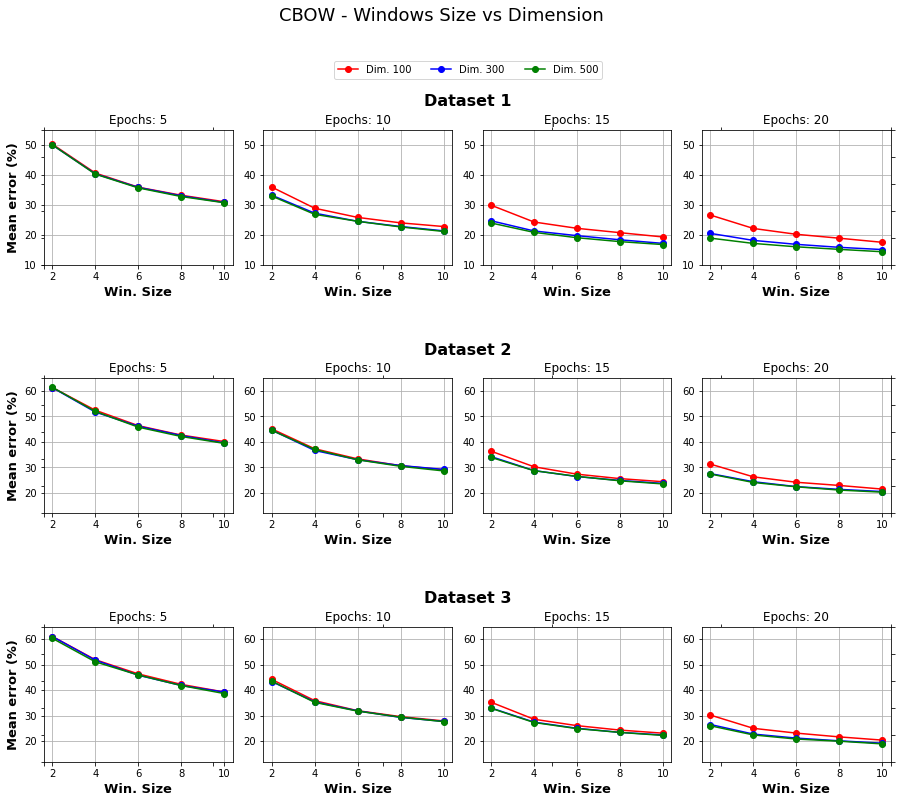

In [17]:
x_axis = [2,4,6,8,10]
line_labels = DIM_NAMES
col_labels = EP_NAMES

y_range = [[10, 55], [12, 65], [12, 65]]
n_rows = 3
n_cols = 4
main_title = 'CBOW - Windows Size vs Dimension'
x_label = 'Win. Size'

plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, DATASET_NAMES, line_labels, col_labels, y_range, COLORS, x_label)

# 5.3.2. SKIP-GRAM

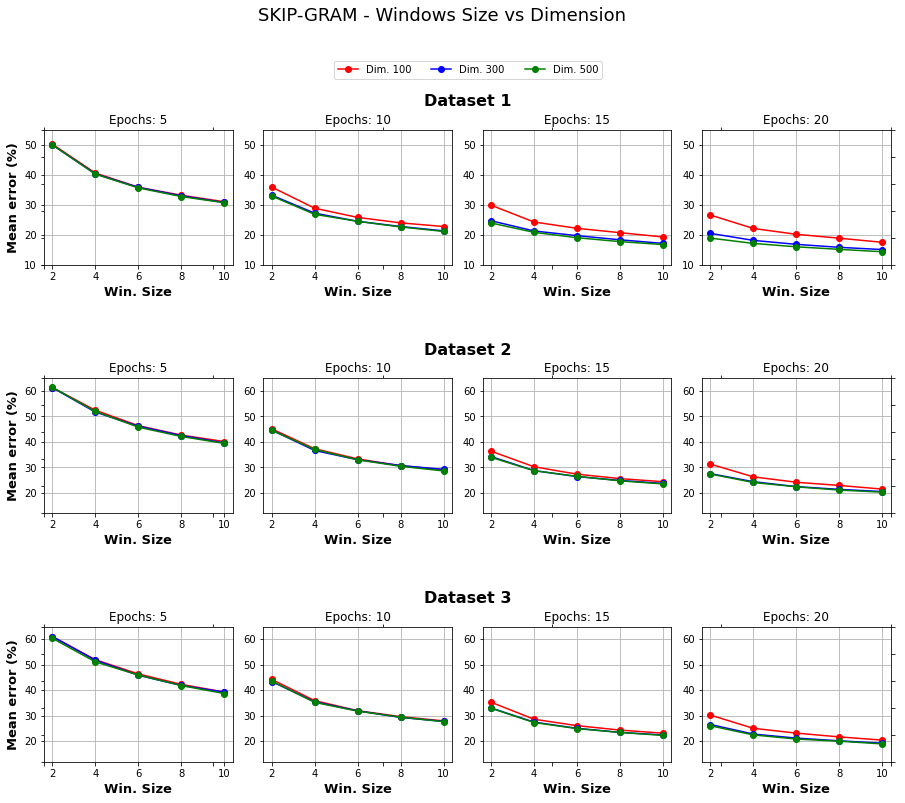

In [18]:
main_title = 'SKIP-GRAM - Windows Size vs Dimension'
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, DATASET_NAMES, line_labels, col_labels, y_range, COLORS, x_label)

# 5.3.3. Observações

Aqui temos as principais afirmações que podem ser feitas a partir dos gráficos observados.

- 1. Não existe uma diferença significativa entre a arquitetura CBOW e SKIP-GRAM.
- 2. Aumentar o número de janelas (win.size) ajuda a diminuir o erro do algoritmo.
- 3. Win.size = 2 é muito pequena, valores próximos a 10 são mais apropriados
- 4. Aumentar o tamanho da janela (win.size) é importante para as diferentes dimensões (100, 300, 500).
- 5. Outro ponto é que com o aumento do número de épocas, os erros vão diminuindo, indicando que valor acima de 15 é o ideal.

**Principal finding:**
- Modificar o tamanho da janela (win. size) impacta diretamente no desempenho dos modelos. A tendência é que aumentando esse valor, o modelo aumente o desempenho, estabilizando em valores próximos a 10. 
- Continuar aumentando o tamanho da janela pode fazer o modelo perder acurácia, uma vez que essa janela captura apenas o contexto importante para aquela palavra. Aumentar muito esse valor, pode atrapalhar o treinamento.

# 5.4. ANÁLISE: Epochs vs Dimensions

**OBJETIVO**: Observar como o aumento de épocas impacta no resultado dos algoritmos.

In [19]:
g_values_cbow = []
g_values_sg = []

for i in range(0, len(DIMENSIONS)):
    for w in WINDOWS:
        for d in DIMENSIONS:
            g_values_cbow.append(get_result_models(['d%s-w%s-e5'%(d,w), 'd%s-w%s-e10'%(d,w), 'd%s-w%s-e15'%(d,w), 'd%s-w%s-e20'%(d,w)], df, i, True))
            g_values_sg.append(get_result_models(['d%s-w%s-e5'%(d,w), 'd%s-w%s-e10'%(d,w), 'd%s-w%s-e15'%(d,w), 'd%s-w%s-e20'%(d,w)], df, i, False))

In [20]:
x_axis = [5,10,15, 20]
line_labels = DIM_NAMES
col_labels = WIN_NAMES

y_range = [[10, 55], [10, 65], [10, 65]]
n_rows = 3
n_cols = 5
main_title = 'CBOW - Epochs vs Dimensions'
x_label = 'Epochs'

# 5.4.1. CBOW

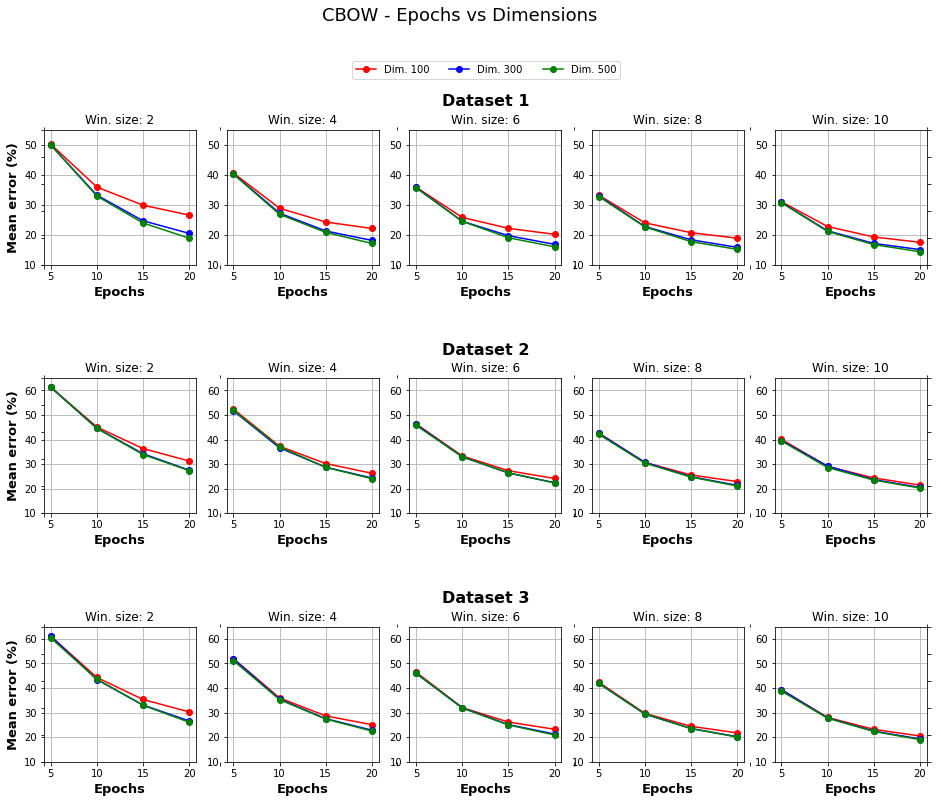

In [21]:
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, DATASET_NAMES, line_labels, col_labels, y_range, COLORS, x_label, 13.5)

# 5.4.2. SKIP-GRAM

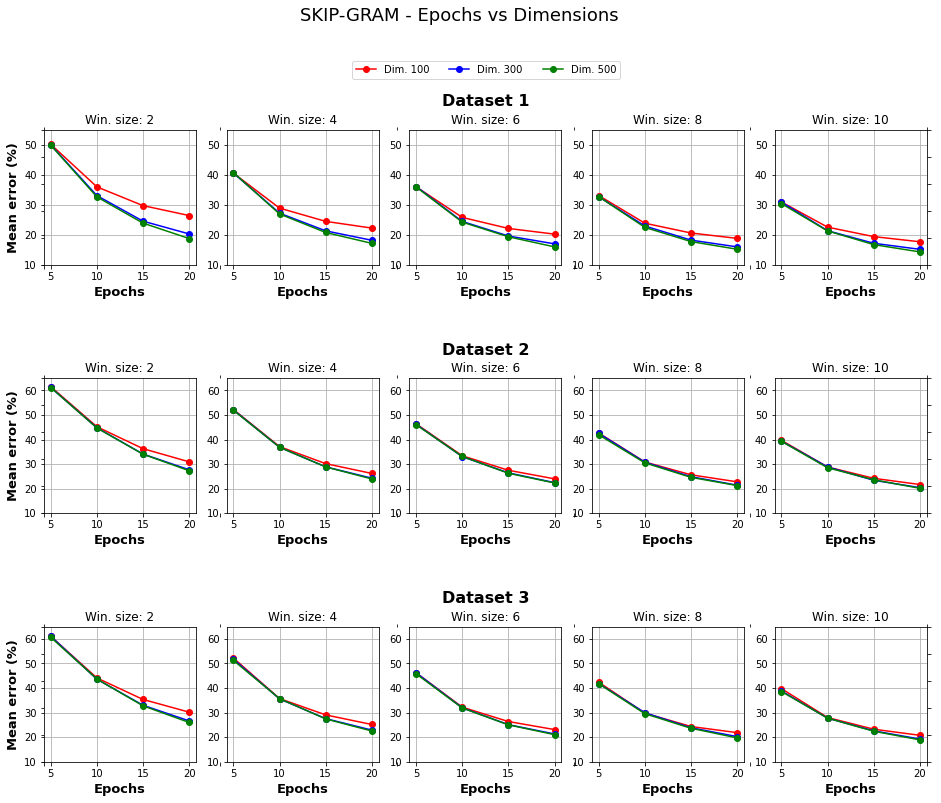

In [22]:
main_title = 'SKIP-GRAM - Epochs vs Dimensions'
plot_graph_rows(n_rows, n_cols, x_axis, g_values_sg, main_title, DATASET_NAMES, line_labels, col_labels, y_range, COLORS, x_label, 13.5)

# 5.4.3. Observações

Analisando os gráficos, podemos fazer algumas observações:

- O aumento do número de épocas é muito importante para o aumento da precisão do algoritmo.
- Um maior número de épocas, faz com que um algoritmo seja melhor treinado. Podemos dizer que, os modelos com apenas 5 épocas estão underfitting, ou seja, a rede neural ainda não conseguiu treinar de maneira a encontrar os principais padrões.
- A tendência é que, se continuarmos aumentando o número de épocas, vamos atingir o limite que o modelo não melhore mais. No entanto, esse limite está próximo a 20 épocas. Vemos isso através da tendência da linha do gráfico.
- As dimensões 300 e 500 apresentam resultados bem próximos. Já a dimensão 100, tem resultado inferior e, mesmo aumentando o número de épocas, continua tendo os piores resultados.
- Isso ocorre uma vez que o menos dimensões, na prática, significa menos pesos e neurônios na rede. Logo, uma rede com menos neurônios, significa uma rede neuronal mais simples e que, possivelmente, captura padrões mais simples.
- Outro fato é o número de janelas (win.size). À medida que o valor aumenta, o erro diminui. Outro parâmetro importante.

#### Principal Finding:
- Aumentar o número de épocas é muito importante, pois garante que o modelo neuronal consiga ser treinado de maneira eficaz, sendo capaz de aprender uma melhor representação para as palavras.



# 5.5. ANÁLISE: Dimensions vs Win. Size

**OBJETIVO**: Observar como o aumento de dimensões impacta no resultado.

In [23]:
g_values_cbow = []
g_values_sg = []

for i in range(0, 3):
    for ep in EPOCHS: 
        for w in WINDOWS: 
            g_values_cbow.append(get_result_models(['d100-w%s-e%s'%(w,ep), 'd300-w%s-e%s'%(w,ep), 'd500-w%s-e%s'%(w,ep)], df, i, True))
            g_values_sg.append(get_result_models(['d100-w%s-e%s'%(w,ep), 'd300-w%s-e%s'%(w,ep), 'd500-w%s-e%s'%(w,ep)], df, i, False))

In [24]:
x_axis = [100, 300, 500]
line_labels = WIN_NAMES
col_labels = EP_NAMES

y_range = [[10, 55], [10, 65], [10, 65], [10, 50], [10, 45]]
n_rows = 3
n_cols = 4
main_title = 'CBOW - Dimension vs Win. Size'
x_label = 'Dimension'

# 5.5.1. CBOW 

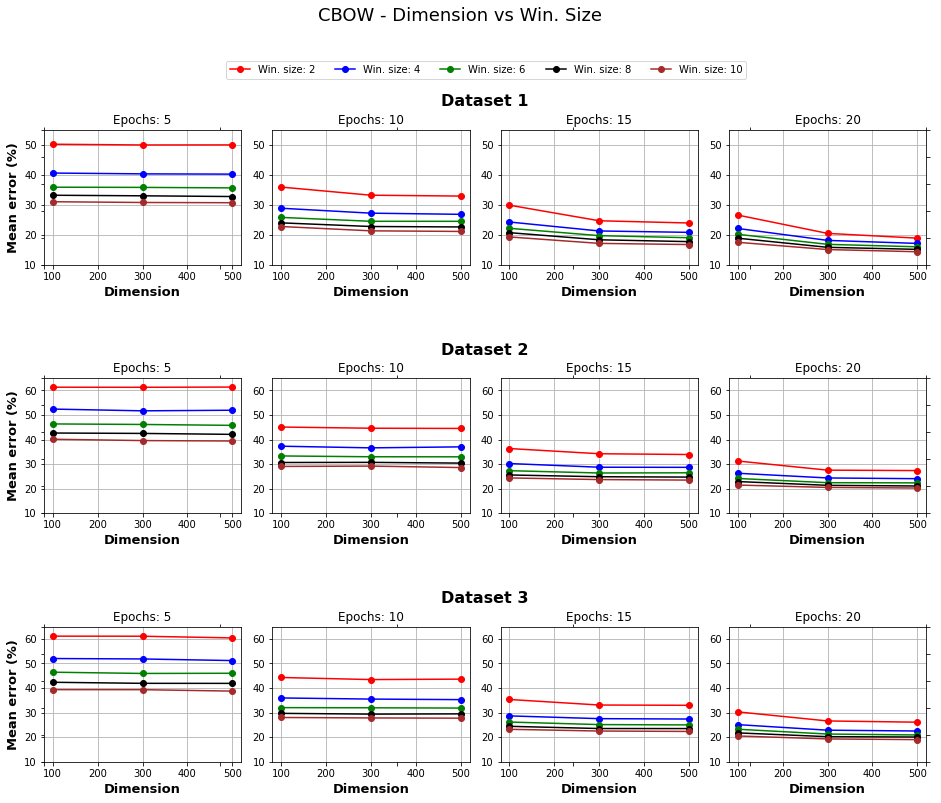

In [25]:
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, DATASET_NAMES, line_labels, col_labels, y_range, COLORS, x_label, 13.5, 5)

# 5.5.2. SKIP-GRAM

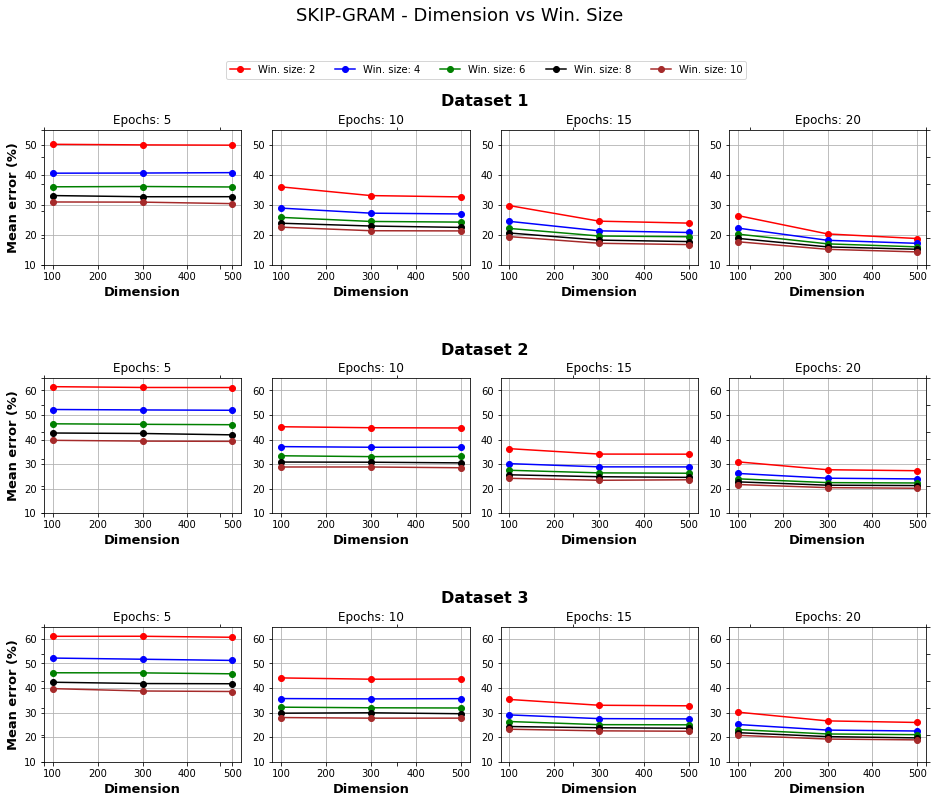

In [26]:
main_title = 'SKIP-GRAM - Dimension vs Win. Size'
plot_graph_rows(n_rows, n_cols, x_axis, g_values_sg, main_title, DATASET_NAMES, line_labels, col_labels, y_range, COLORS, x_label, 13.5, 5)

# 5.5.3. Observações

Esses gráficos trazem questões interessantes a serem discutidas:

- O primeiro ponto é que: aumentar apenas a dimensão do modelo sem ajustar outros parâmetros não leva a um aumento de precisão.
- Na prática, aumentar a dimensão, significa aumentar o número de neurônios e pesos da rede, deixando ela mais completa. Assim, não aumentando o número de épocas ou janelas, a tendência é que a inclusão dos novos neurônios não seja suficiente para aprender novos padrões. Ou seja, aumentamos a capacidade da rede, mas não ajustamos o treinamento.
- A exceção ocorre quando se tem 20 épocas. Nesse caso, vemos uma diferença significativa de 100 para 300 dimensões. Isso ocorre pois, com mais épocas, os neurônios podem ser melhor treinados.
- Observe que, aumentando o número de épocas, o erro agregado vai diminuindo.
- O número da janela (win.size) é outro fator importante. Janela = 2 tem o pior resultado. De maneira contrária, janela = 10 tem o melhor resultado. Aumentar esse parâmetro ajuda a aumentar a precisão.

**Principal Finding:**
- Aumentar apenas a dimensão sem alterar outros parâmetros não nos leva a um aumento de precisão. É necessário aumentar o número de épocas e win. size.


# 5.6. ANÁLISE: CBOW vs SKIP-GRAM

**OBJETIVO**: Verficar a diferença dos resultados quando se usa uma arquitetura diferente.

In [27]:
g_values = []

for i in range(0, len(DIMENSIONS)):
    for w in WINDOWS:
        g_values.append(get_result_models(['d100-w%s-e20'%(w), 'd300-w%s-e20'%(w), 'd500-w%s-e20'%(w)], df, i, True))
        g_values.append(get_result_models(['d100-w%s-e20'%(w), 'd300-w%s-e20'%(w), 'd500-w%s-e20'%(w)], df, i, False))


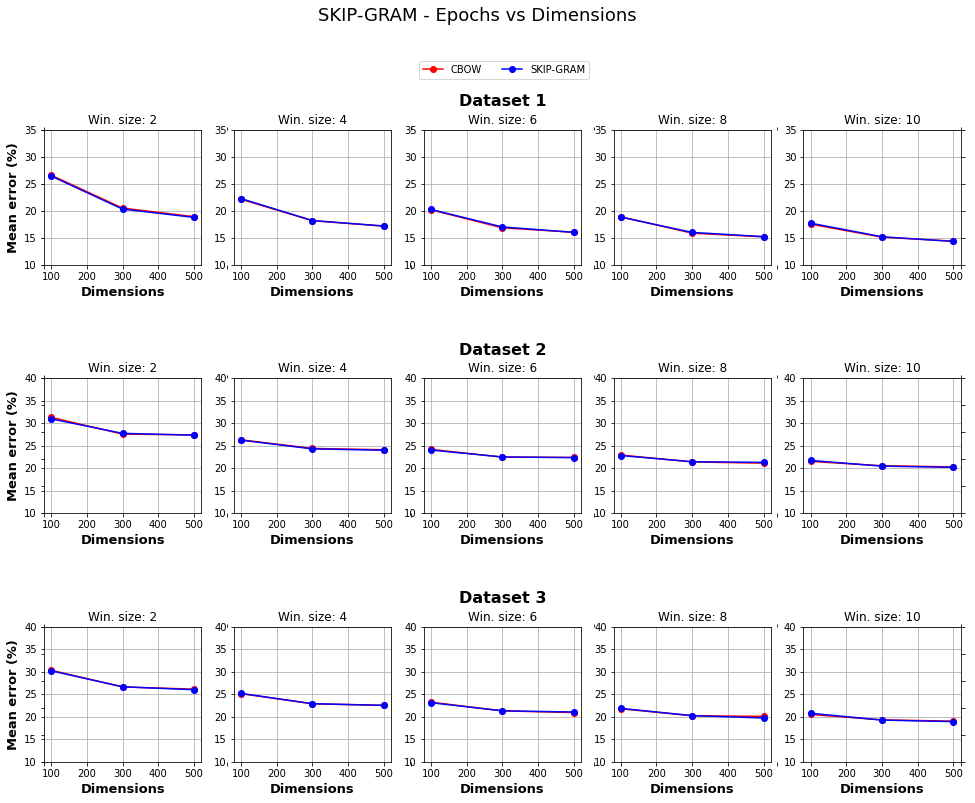

In [28]:
x_axis = [100,300,500]
line_labels = ['CBOW', 'SKIP-GRAM']
col_labels = WIN_NAMES

y_range = [[10, 35], [10, 40], [10, 40]]
n_rows = 3
n_cols = 5
main_title = 'CBOW vs SKIP-GRAM'
x_label = 'Dimensions'

main_title = 'SKIP-GRAM - Epochs vs Dimensions'
plot_graph_rows(n_rows, n_cols, x_axis, g_values, main_title, DATASET_NAMES, line_labels, col_labels, y_range, COLORS, x_label, 14, n_lines=2)

# 5.6.1. Observações

Todos os gráficos são plotados considerando 20 épocas. Com isso percebemos que:

- Na comparação de arquiteturas, percebemos que a mudança de CBOW para SKIP-GRAM resulta em uma pequena mudança, que não é significativa.

- As linhas dos gráficos praticamente são idênticas, independentemente do dataset.
- Novamente, aumentar a dimensão tem uma pequena diferença. Percebemos que ocorre uma melhora quando aumentando de 100 para 300 dimensões. No entanto, de 300 para 500, a diferença é bem menor.


**Principal Finding:**
- Apenas mudar a arquitetura da rede não resulta em uma mudança significativa. Essa alteração precisa estar associada a uma modificação dos outros parâmetros.

# 5.7. ANÁLISE: Base de Dados

**OBJETIVO**: Análise da diferente da base de dados para o desempenho do algoritmo.

In [29]:
g_values_cbow = []
g_values_sg = []

for d in DIMENSIONS:
    for ep in EPOCHS:
        for i in range(0, len(DIMENSIONS)):
            g_values_cbow.append(get_result_models(['d%s-w2-e%s'%(d, ep), 'd%s-w4-e%s'%(d, ep), 'd%s-w6-e%s'%(d, ep), 'd%s-w8-e%s'%(d, ep), 'd%s-w10-e%s'%(d, ep)], df, i, True))
            g_values_sg.append(get_result_models(['d%s-w2-e%s'%(d, ep), 'd%s-w4-e%s'%(d, ep), 'd%s-w6-e%s'%(d, ep), 'd%s-w8-e%s'%(d, ep), 'd%s-w10-e%s'%(d, ep)], df, i, False))    

In [30]:
x_axis = WINDOWS
line_labels = DATASET_NAMES
col_labels = EP_NAMES

y_range = [[10, 65], [10, 65], [10, 65]]
n_rows = 3
n_cols = 4
main_title = 'CBOW - Dimension vs Dataset'
x_label = 'Win. Size'

# 5.7.1. CBOW

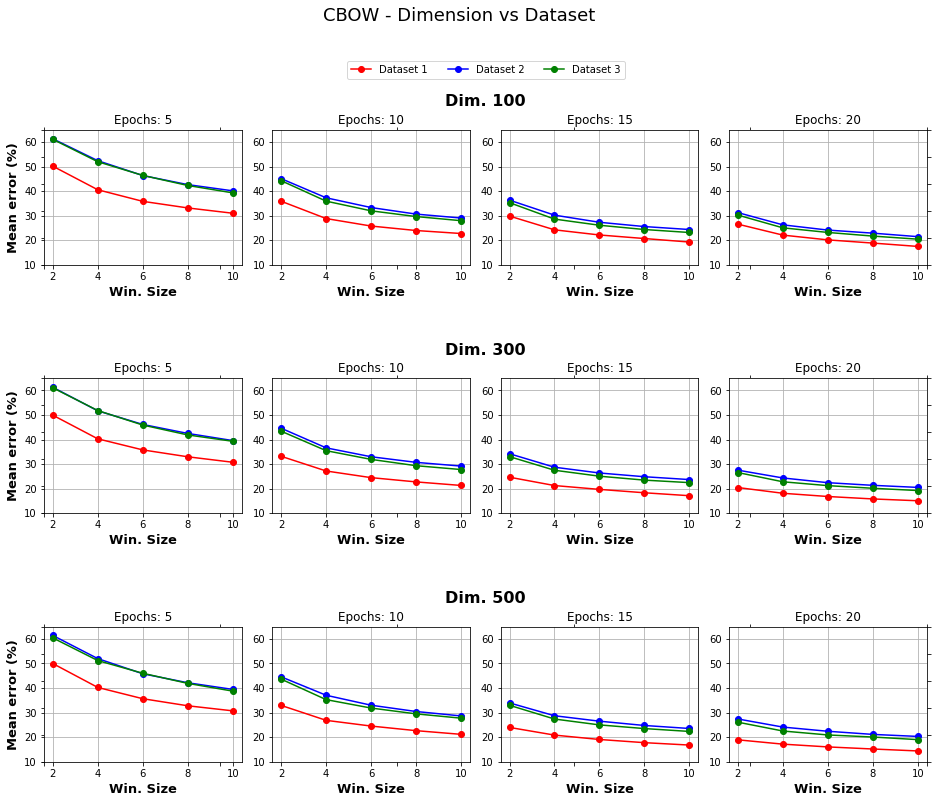

In [31]:
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, DIM_NAMES, line_labels, col_labels, y_range, COLORS, x_label, 13.5, n_lines=3)

# 5.7.2. SKIP-GRAM

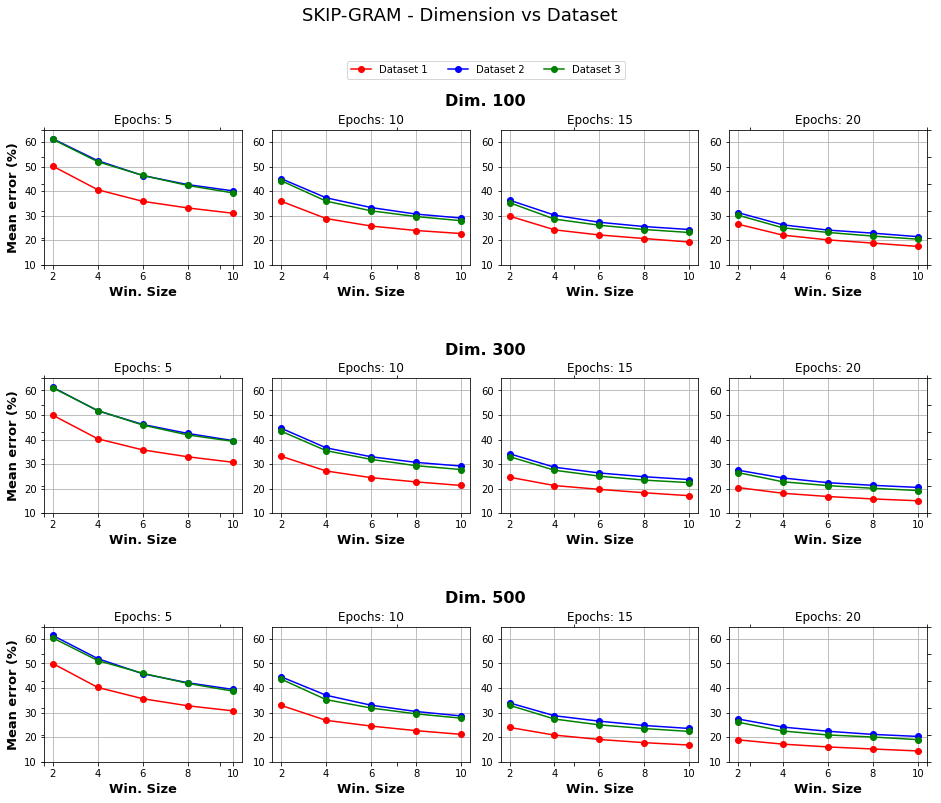

In [32]:
main_title = 'SKIP-GRAM - Dimension vs Dataset'
plot_graph_rows(n_rows, n_cols, x_axis, g_values_cbow, main_title, DIM_NAMES, line_labels, col_labels, y_range, COLORS, x_label, 13.5, n_lines=3)

# 5.7.3. Observações

Nesta parte, comparamos o resultado obtido em cada base de dados.

- O **Dataset 1** tem os melhores resultados, isso porque possui mais palavras e tem um vocabulário bem maior.
- Isso mostra que, de fato, um bom conjunto de dados é crucial para o desempenho.
- Percebemos que aumentar a época é importante. Os valores vão se aproximando à medida que aumentamos a época e o win.size. A tendência é que vão chegando a um limite.


# 5.8. FINDINGS GERAL

Observando todos os gráficos dessa seção, podemos chagar a algumas conclusões, são elas:


# 6. ANÁLISE: Base de Dados

Nesta seção, iremos fazer algumas comparações mais diretas de cada base de dados, e de cada um dos parâmetros analisados.

In [33]:
df_dataset1 = df.loc[df['model'].str.contains('all_data')]
df_dataset2 = df.loc[df['model'].str.contains('data1')]
df_dataset3 = df.loc[df['model'].str.contains('data2')]

# 6.1. Qual Dataset Apresenta o Melhor Desempenho?


In [34]:
precision = []
p1 = 100 - np.mean(df.loc[df['model'].str.contains('all_data')]['mean']) * 100
p2 = 100 - np.mean(df.loc[df['model'].str.contains('data1')]['mean']) * 100
p3 = 100 - np.mean(df.loc[df['model'].str.contains('data2')]['mean']) * 100


r1 = (1 - np.mean(df.loc[df['model'].str.contains('all_data')]['num_words_miss'])/TOTAL_WORDS_COMBINE) * 100
r2 = (1 - np.mean(df.loc[df['model'].str.contains('data1')]['num_words_miss'])/TOTAL_WORDS_COMBINE)* 100
r3 = (1 -np.mean(df.loc[df['model'].str.contains('data2')]['num_words_miss'])/TOTAL_WORDS_COMBINE)*100

precision.append([p1, p2, p3])
precision.append([r1, r2, r3])

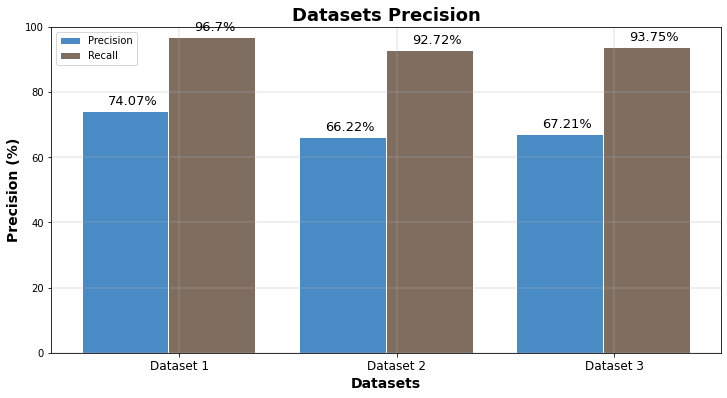

In [35]:
x_label = ['Precision', 'Recall']
title = "Datasets Precision"
x_title = "Datasets"
y_title = "Precision (%)"

plot_bar_graph(precision, x_label, DATASET_NAMES, title, x_title, y_title, n_bar=2, n_bar_grouped=3, size=(12,6), barwith=0.40)

## Observações

Aqui, podemos ver mais detalhadamente qual conjunto de dados teve um melhor resultado no treinamento dos algoritmos. A base de dados 1, que é a mais completa, atingiu os melhores resultados. 

Temos duas métricas: 
- 1. Precisão: valor médio de todos os modelos treinados na base de dados. Ou seja, o quão próxima a palavra prevista do modelo está próxima a palavra correta.
- 2. Recall: porcentagem das palavras da validação que foram encontradas no vocabulário do modelo de linguagem.

Sendo assim, podemos dizer que: quanto mais completo o dataset usado, melhor o modelo de linguagem gerado.

# 6.2. Qual o Melhor Valor para Win. Size?

In [36]:
win = ['w2', 'w4', 'w6', 'w8', 'w10']
y_axis = []

for i in range(0, 5):
    df_local = df_dataset1 if i == 0 else df_dataset2 if i == 1 else df_dataset3
    y_value = []
    y_value.append(100 - np.mean(df_dataset1.loc[df_dataset1['model'].str.contains(win[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset2.loc[df_dataset2['model'].str.contains(win[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset3.loc[df_dataset3['model'].str.contains(win[i])]['mean']) * 100)
    
    y_axis.append(y_value)


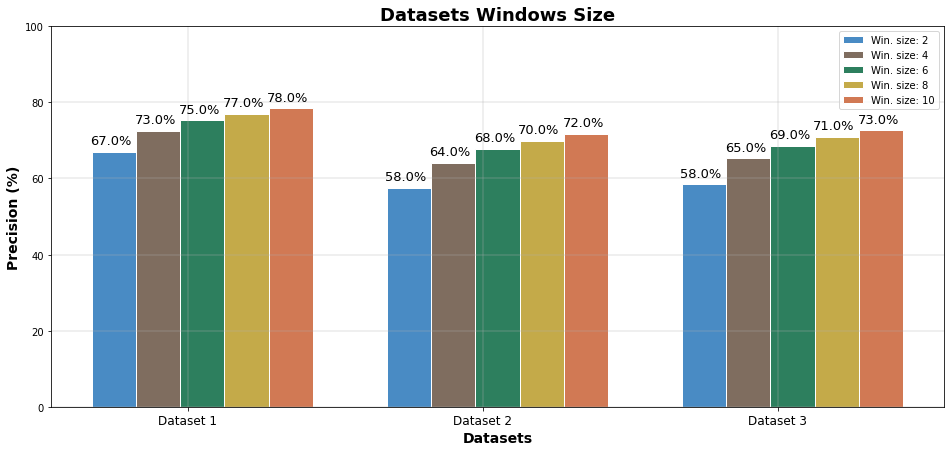

In [37]:
x_label = WIN_NAMES
title = "Datasets Windows Size"
x_title = "Datasets"
y_title = "Precision (%)"

plot_bar_graph(y_axis, x_label, DATASET_NAMES, title, x_title, y_title, n_bar=5, n_bar_grouped=3, size=(16,7), barwith=0.15, val_round=0)

## Observações

O número de janelas ajuda o modelo a selecionar o contexto que será utilizado para prever a próxima palavra. De maneira geral, janelas muito pequenas não são interessantes, porque não capturam o contexto necessário. Valores acima de 10 é o ideal. Possivelmente se continuarmos aumentando o valor, chegaremos a um limite de precisão, uma vez que tamanhos muito grande captam além do contexto necessário.

De maneira geral, aumentar o número de janelas é crucial para o treinamento do modelo.

# 6.3. Qual o Melhor Número de Épocas?

In [38]:
ep = ['e5', 'e10', 'e15', 'e20']
y_axis = []

for i in range(0, 4):
    df_local = df_dataset1 if i == 0 else df_dataset2 if i == 1 else df_dataset3
    y_value = []
    y_value.append(100 - np.mean(df_dataset1.loc[df_dataset1['model'].str.contains(ep[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset2.loc[df_dataset2['model'].str.contains(ep[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset3.loc[df_dataset3['model'].str.contains(ep[i])]['mean']) * 100)
    y_axis.append(y_value)
    

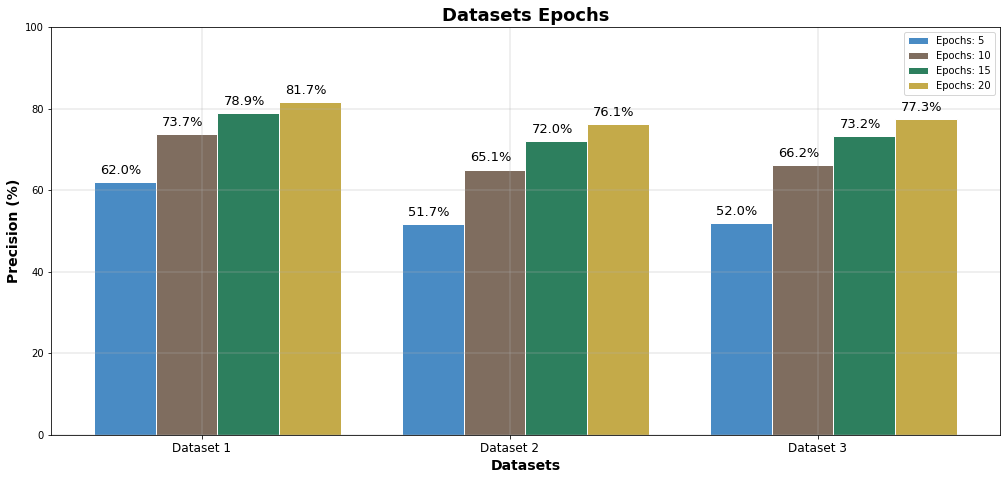

In [39]:
x_label = EP_NAMES
title = "Datasets Epochs"
x_title = "Datasets"
y_title = "Precision (%)"

plot_bar_graph(y_axis, x_label, DATASET_NAMES, title, x_title, y_title, n_bar=4, n_bar_grouped=3, size=(17,7.5), barwith=0.20, val_round=1)

## Observações

Novamente, a quantidade de épocas é importante para o treinamento, talvez um dos principais parâmetros. À medida que aumentamos o valor, o modelo é capaz de treinar e aprender novos padrões. Para o nosso contexto, valores acima de 20 é o ideal.

# 6.4. Qual a Melhor Arquitetura? CBOW ou SKIP-GRAM?

In [40]:
arq = ['cbow', 'skip_gram']
y_axis = []

for i in range(0, 2):
    df_local = df_dataset1 if i == 0 else df_dataset2 if i == 1 else df_dataset3
    y_value = []
    y_value.append(100 - np.mean(df_dataset1.loc[df_dataset1['model'].str.contains(arq[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset2.loc[df_dataset2['model'].str.contains(arq[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset3.loc[df_dataset3['model'].str.contains(arq[i])]['mean']) * 100)
    y_axis.append(y_value)
    

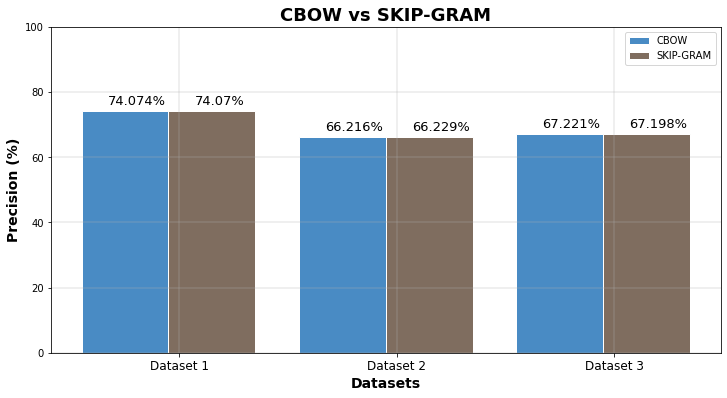

In [41]:
x_label = ['CBOW', 'SKIP-GRAM']
title = "CBOW vs SKIP-GRAM"
x_title = "Datasets"
y_title = "Precision (%)"

plot_bar_graph(y_axis, x_label, DATASET_NAMES, title, x_title, y_title, n_bar=2, n_bar_grouped=3, size=(12, 6), barwith=0.40, val_round=3)

## Observações

Independentemente da base de dados, as duas arquitetura apresentam resultados semelhantes. Isso nos leva a concluir que: mudar apenas a arquitetura não nos leva a uma aumento da precisão. Na verdade, a combinação dos outros paramêtros leva a uma melhor precisão. A arquitetura de maneira isolada nos resulta em um aumento de precisão.

# 6.4. Qual a Melhor Dimensão?

In [42]:
dim = ['d100', 'd300', 'd500']
y_axis = []

for i in range(0, 3):
    df_local = df_dataset1 if i == 0 else df_dataset2 if i == 1 else df_dataset3
    y_value = []
    y_value.append(100 - np.mean(df_dataset1.loc[df_dataset1['model'].str.contains(dim[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset2.loc[df_dataset2['model'].str.contains(dim[i])]['mean']) * 100)
    y_value.append(100 - np.mean(df_dataset3.loc[df_dataset3['model'].str.contains(dim[i])]['mean']) * 100)
    
    y_axis.append(y_value)

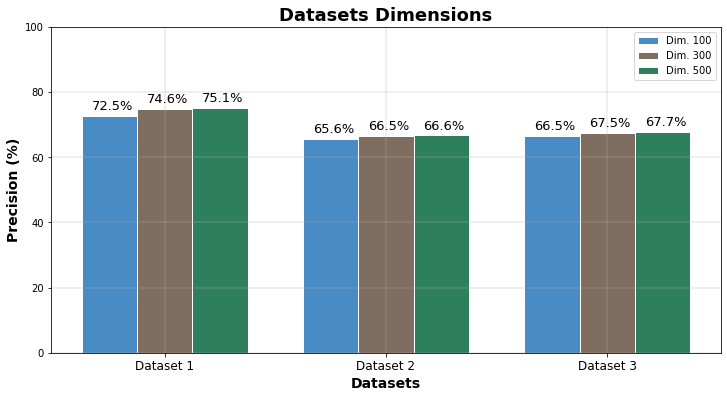

In [43]:
x_label = DIM_NAMES
title = "Datasets Dimensions"
x_title = "Datasets"
y_title = "Precision (%)"

plot_bar_graph(y_axis, x_label, DATASET_NAMES, title, x_title, y_title, n_bar=3, n_bar_grouped=3, size=(12,6), barwith=0.25, val_round=1)

 ## Observações

Aumentar a dimensão ajuda a ampliar a capacidade do modelo. Ou seja, com maior dimensão o modelo consegue aprender padrões mais complexos. De certa forma, a mudança apenas desse valor não resulta em um resultado tão superior. Essa mudança precisa estar associada ao aumento de épocas e win.size, por exemplo.

Mesmo assim, podemos dizer que valores entre 300 e 500, são os mais indicados para este problema.

# 7. Qual o Melhor Modelo?

In [44]:
m1 = df_dataset1.sort_values(by=["mean"], ascending=[True]).iloc[0]
m2 = df_dataset2.sort_values(by=["mean"], ascending=[True]).iloc[0]
m3 = df_dataset3.sort_values(by=["mean"], ascending=[True]).iloc[0]

print('DATASET 1')
print('- Model: ', m1['model'])
print('- Precision: ', str(100 - round(m1['mean'], 4) * 100) + '%')

print('\nDATASET 2')
print('- Model: ', m2['model'])
print('- Precision: ', str(100 - round(m2['mean'], 4) * 100) + '%')

print('\nDATASET 3')
print('- Model: ', m3['model'])
print('- Precision: ', str(100 - round(m3['mean'], 4) * 100) + '%')

DATASET 1
- Model:  all_data-skip_gram-d500-w10-e20.model
- Precision:  85.65%

DATASET 2
- Model:  data1-skip_gram-d500-w10-e20.model
- Precision:  79.78%

DATASET 3
- Model:  data2-skip_gram-d500-w10-e20.model
- Precision:  81.08%


### Observação

Observando o melhor modelo para cada base de dados, percebemos que eles compartilham os mesmos parâmetros, são eles:
- Arquitetura: SKIP-GRAM
- Dimensão: 500
- Win.Size: 10
- Época: 20

É interessante perceber que o SKIP-GRAM leva uma pequena vantagem em relação ao CBOW, o que vai de encontro com a afirmação feita por Tomas Mikolov, criador do algoritmo, que diz que o SKIP-GRAM funciona bem em pequenas bases de dados.

No entanto, essa diferença não é significativa. Com os resultados, podemos dizer que o CBOW e SKIP-GRAM apresentam resultados semelhantes estatisticamente.

Sobre os demais parâmetros, percebemos que valores maiores de época, janela, dimensão, são mais interessantes. Apesar de existir um limite, um número maior de épocas ajuda o modelo a ter um treinamento mais eficaz.

De maneira geral, independentemente da base de dados, o melhor modelo compartilha os mesmos parâmetros.

# 8. CONCLUSÃO

Após realizar todo o treinamento e avaliação, podemos sumarizar os resultados em alguns pontos:

Detalhamento sobre cada um dos parâmetros:

- **Épocas**: É um dos principais parâmetros, além de ser muito importânte para o bom desempenho dos modelos. Na prática, encontramos que valores acima de 20 épocas são interessantes.

- **Win. Size**: Outro parâmetro muito importante, pois é responsável por selecionar o contexto que será usado para prever a próxima palavra. Valores acima de 10 são os mais indicados, tanto para SKIP-GRAM e quanto para o CBOW

- **Dimensão**: A dimensão é outro ponto interessante. Aumentando apenas esse valor, percebemos que não traz uma melhoria significativa. Dimensão = 100 não se mostrou tão eficiente quanto a de 500. No entanto, o aumento da dimensão precisa estar associado com o aumento de épocas. Caso contrário, a rede não será capaz de ser treinada de maneira eficaz. 

- **Arquitetura**: O SKIP-GRAM apresentou o melhor resultado se compararmos com todos os modelos. No entanto, essa diferença não é significativa. Podemos dizer que esse parâmetro foi o que menos afetou no desempenho dos modelos.

- **Base de Dados**: O Dataset 1 apresentou o melhor desempenho, uma vez que possui todo o corpus **text8**. Isso nos confirma que, uma base de dados com bastante exemplos é muito importante para o treinamento. Talvez, umas das coisas mais importantes.

**Conclusões Finais**
- De maneira geral, podemos concluir que: a junção de vários fatores que levam a um modelo mais eficiente. É muito importante que se teste vários parâmetros, até encontrar a combinação ideal. 

- Apesar de não testarmos todos os parâmetros possíveis, é possível ver a tendência de cada um deles. Ou seja, no caso do número de janelas, apesar de não testarmos valores acima de 10, sabemos que o número ideal está próximo a isso devido à linha de tendência do gráfico.